In [5]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install scipy
from scipy import stats
from scipy import optimize

# Learning in Repeated Advertising Auctions

## Click Visualization Model

### Important Quantities
Given and ad $a$ and a slot $s$, each time $t$ a user arrives:
- $\lambda_s$: probability that the slot $s$ is observed by the user.
- $q_a$: ad's *click-through-rate*, i.e., probability that the ad is clicked by user
- $v_a$: ad's profit per click (e.g., expected profit from sale)

### Assumptions of this model:

- All the quantities are **fixed** and don't vary with time.
- Ad's CTR $q_a$ and profit-per-click $v_a$ don't depend on the slot.
- Prominence $\lambda_s$ pdoesn't depend on ad.

In [6]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


# Truthful Auctions

## Publisher's Perspective

### Single slot

In [7]:
class SecondPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)

In [8]:
# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.array([0.8, 0.65, 0.50, 0.75])
v = np.array([0.7, 1.1, 1.4, 0.85])

# environmental settings
n_users= 3

auction = SecondPriceAuction(ctrs=ctrs)
for u in range(n_users):
    print(f'# User {u}')
    bids = np.random.choice([0.25, 0.5, 0.75, 1], size=n_adv)
    pub_values = bids*ctrs
    print(f'Bids: {bids}, Publisher Values: {pub_values}')
    winner, payment_per_click = auction.round(bids=bids)
    print(f'Auction Winner: {winner}, Payment-per-click: {payment_per_click}')
    print(f'Payment <= Bid : {payment_per_click <= bids[winner]}')


# User 0
Bids: [0.75 0.5  0.25 1.  ], Publisher Values: [0.6   0.325 0.125 0.75 ]
Auction Winner: 3, Payment-per-click: 0.8
Payment <= Bid : True
# User 1
Bids: [0.25 0.75 0.75 0.75], Publisher Values: [0.2    0.4875 0.375  0.5625]
Auction Winner: 3, Payment-per-click: 0.65
Payment <= Bid : True
# User 2
Bids: [0.75 0.5  0.25 0.5 ], Publisher Values: [0.6   0.325 0.125 0.375]
Auction Winner: 0, Payment-per-click: 0.47
Payment <= Bid : True


### Multiple Slots

#### WARNING: in Slide 17 of package 6.Auctions, there's a typo: the payment is $p_a = \frac{Y_a-X_a}{\lambda_{s(a)}q_a}$ (not $X_a-Y_a$!)

In [9]:
class VCGAuction(Auction):
    def __init__(self, ctrs, lambdas):
        self.ctrs = ctrs
        self.lambdas = lambdas
        self.n_adv = len(self.ctrs)
        self.n_slots = len(self.lambdas)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.n_slots:]
        winners_values = adv_values[winners]
        return winners, winners_values
    
    def get_payments_per_click(self, winners, values, bids):
        payments_per_click = np.zeros(self.n_slots)
        for i,w in enumerate(winners):
            Y = sum(np.delete(values, i)*self.lambdas[-self.n_slots+1:])
            X = sum(np.delete(values*self.lambdas, i))
            payments_per_click[i] = (Y-X)/(self.lambdas[i]*self.ctrs[w])
        return payments_per_click.round(2)

In [10]:
# publisher's fixed parameters
n_slots = 3
lmbd = np.array([0.4, 0.6, 0.8]) # assumed to be decreasing

# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.array([0.8, 0.65, 0.50, 0.75])
v = np.array([0.7, 1.1, 1.4, 0.85])

# environmental settings
n_users= 10

auction = VCGAuction(ctrs=ctrs, lambdas=lmbd)
for u in range(n_users):
    print(f'# User {u}')
    bids = np.random.choice([0.25, 0.5, 0.75, 1], size=n_adv)
    pub_values = bids*ctrs
    print(f'Bids: {bids}, Publisher Values: {pub_values}')
    winners, payments_per_click = auction.round(bids=bids)
    print(f'Auction Winners: {winners}, Payment-per-click: {payments_per_click}')
    print(f'Payment <= Bid : {(payments_per_click <= bids[winners]).all()}')


# User 0
Bids: [1.   0.5  0.5  0.75], Publisher Values: [0.8    0.325  0.25   0.5625]
Auction Winners: [1 3 0], Payment-per-click: [0.   0.14 0.28]
Payment <= Bid : True
# User 1
Bids: [1.   1.   0.5  0.75], Publisher Values: [0.8    0.65   0.25   0.5625]
Auction Winners: [3 1 0], Payment-per-click: [0.   0.29 0.38]
Payment <= Bid : True
# User 2
Bids: [1.   0.5  0.75 0.75], Publisher Values: [0.8    0.325  0.375  0.5625]
Auction Winners: [2 3 0], Payment-per-click: [0.   0.17 0.29]
Payment <= Bid : True
# User 3
Bids: [1.   1.   0.75 0.25], Publisher Values: [0.8    0.65   0.375  0.1875]
Auction Winners: [2 1 0], Payment-per-click: [0.   0.19 0.32]
Payment <= Bid : True
# User 4
Bids: [0.5  0.25 0.75 0.75], Publisher Values: [0.4    0.1625 0.375  0.5625]
Auction Winners: [2 0 3], Payment-per-click: [0.   0.16 0.26]
Payment <= Bid : True
# User 5
Bids: [0.75 0.25 0.75 1.  ], Publisher Values: [0.6    0.1625 0.375  0.75  ]
Auction Winners: [2 0 3], Payment-per-click: [0.   0.16 0.33]
Pa

## Advertiser's Perspective: learning in repeated second price auctions

#### We will assume, from now on, that all CTRs are equal to 1.

#### What is the best **and feasible** sequence of bids I can do? How much cumulative utility does a clairvoyant gain?

In [11]:
### Deterministic Bidders: my competitors always bid the same amount until budget depletion

n_advertisers = 3
n_users = 1000
B = 50

# simple scenario: competitors fix their bids
other_bids = np.repeat(np.array([0.2,0.5,0.7]).reshape(-1,1), n_users, axis=1)
## budget depletes after B/bid rounds
other_bids[0,int(B/0.2):] = 0
other_bids[1,int(B/0.5):] = 0
other_bids[2,int(B/0.7):] = 0
# easy scenario: I assume competitors to have the same budget as mine (they could have more in practica)
# and that they behave greedily, always bidding until budget depletion

m_t = other_bids.max(axis=0) ## highest bid at each round
m_t[:150]

array([0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

#### I know, for each round, what will be the highest bid. Now I have to solve an optimization problem and find out how to allocate my bids optimally.

In [12]:
### As a re-usable function:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0
    i = 0
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

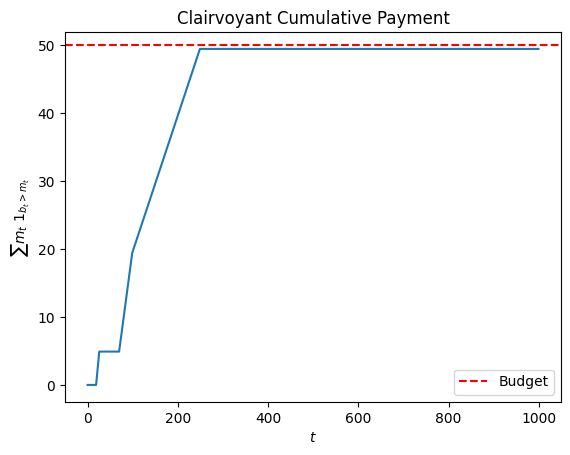

In [13]:
B = 50
ctr = 1
value_per_click = 0.8
my_valuation = ctr*value_per_click

clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)

plt.title('Clairvoyant Cumulative Payment')
plt.plot(np.cumsum(clairvoyant_payments))
plt.axhline(B, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

#### The optimal policy makes the other bidders deplete their budgets first, and then exploits the auction as a unique bidder!

In [14]:
### Stochastic Bidders: my competitors sample their bids from 
### probability distributions

n_advertisers = 3
n_users = 1000
B = 50

# simple scenario: competitors sample bids from a uniform 
other_bids = np.random.uniform(0, 10*B/n_users, size = (n_advertisers, n_users))
# I assume that competitors may have a larger budget than mine (10*B), but they may
# not deplete it.

In [15]:
m_t = other_bids.max(axis=0) ### maximum bid at every round, NOT IN EXPECTATION
m_t[:10]

array([0.45223214, 0.26611869, 0.40749055, 0.28599583, 0.37739398,
       0.44187819, 0.42574795, 0.43513972, 0.31551306, 0.34228519])

#### I can, again, use the greedy strategy for find the clairvoyant's bids and utilities

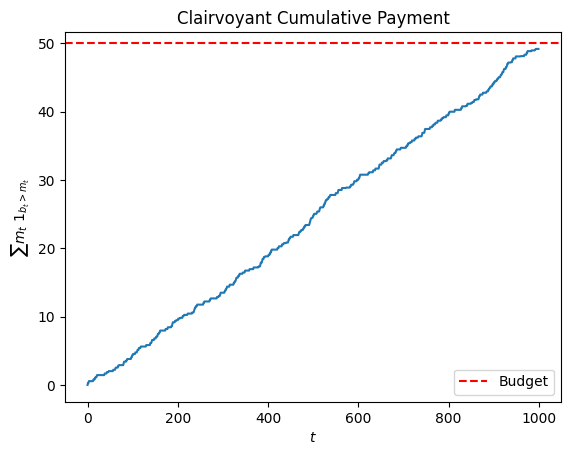

In [16]:
B = 50
my_valuation = 0.8

clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)

plt.title('Clairvoyant Cumulative Payment')
plt.plot(np.cumsum(clairvoyant_payments))
plt.axhline(B, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

#### What agent can I design without knowing all the information a priori?

### Budget Pacing

In [17]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

In [18]:
# advertisers' fixed parameters
## we assume that our agent has the FIRST index, e.g. our q_a*v_a = 0.56
n_advertisers = 4 # four advertisers, including myself
ctrs = np.ones(n_advertisers)
my_valuation = 0.8
B = 150

# environmental settings
n_users = 1000

# competitors
other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users))
m_t = other_bids.max(axis=0)
## I'm considering competitors stronger than me, since they are free to exceed my budget

clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)

In [19]:
eta = 1/np.sqrt(n_users) # from theory
agent = MultiplicativePacingAgent(valuation=my_valuation,
                                  budget=B,
                                  T=n_users, 
                                  eta=eta)

auction = SecondPriceAuction(ctrs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(18)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t)
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 254


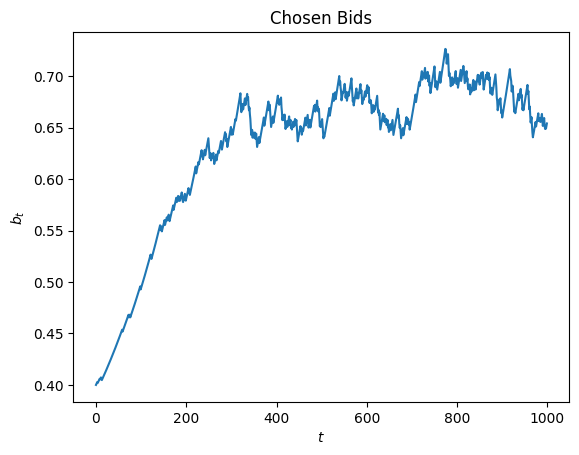

In [20]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

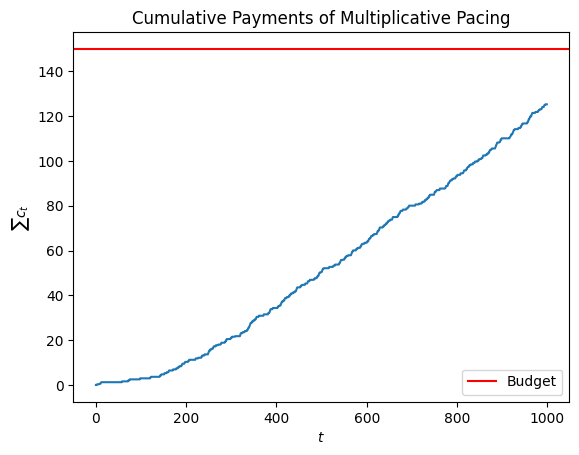

In [21]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

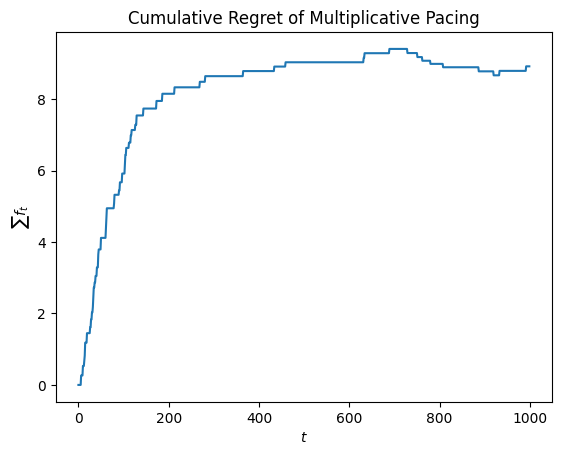

In [22]:
cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

# Non-Truthful Auctions

#### In non-truthful auctions, we additionally assume that the **bids are discretized in a finite set**.

## Publisher's Perspective

### Single Slot

In [23]:
class FirstPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        payment = bids[winners]
        return payment.round(2)

In [24]:
# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.array([0.8, 0.65, 0.50, 0.75])
v = np.array([0.7, 1.1, 1.4, 0.85])

# environmental settings
n_users= 3

auction = FirstPriceAuction(ctrs=ctrs)
for u in range(n_users):
    print(f'# User {u}')
    bids = np.random.choice([0.25, 0.5, 0.75, 1], size=n_adv)
    pub_values = bids*ctrs
    print(f'Bids: {bids}, Publisher Values: {pub_values}')
    winner, payment_per_click = auction.round(bids=bids)
    print(f'Auction Winner: {winner}, Payment-per-click: {payment_per_click}')
    print(f'Payment == Bid : {payment_per_click == bids[winner]}')


# User 0
Bids: [0.75 1.   0.25 0.5 ], Publisher Values: [0.6   0.65  0.125 0.375]
Auction Winner: 1, Payment-per-click: 1.0
Payment == Bid : True
# User 1
Bids: [0.75 0.5  0.75 0.75], Publisher Values: [0.6    0.325  0.375  0.5625]
Auction Winner: 0, Payment-per-click: 0.75
Payment == Bid : True
# User 2
Bids: [0.75 0.25 0.25 0.75], Publisher Values: [0.6    0.1625 0.125  0.5625]
Auction Winner: 0, Payment-per-click: 0.75
Payment == Bid : True


## Advertiser's Perspective: learning in repeated first price auctions

#### We assume from now on that all CTRs are equal to 1

#### What is the best **and feasible** sequence of bids I can do? How much cumulative utility does a clairvoyant gain?

In [25]:
### Stochastic Bidders: my competitors sample their bids from 
### probability distributions

n_advertisers = 3
n_users = 1000
B = 50
my_valuation = 0.6
rho = B/n_users

# simple scenario: competitors sample bids from a uniform 
other_bids = np.random.uniform(0, 1, size = (n_advertisers, n_users))
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.
m_t = other_bids.max(axis=0)

#### We are in a **stochastic** environment, thus we can use a notion of clairvoyant in **expectation**, i.e., the clairvoyant doesn't know all the actual bids but their distributions only. This clairvoyant is weaker than the one presented for truthful auctions. However, it is allowed to exceed budget (it only satisfies the budget constraint in expectation).

#### This is our optimization problem for the stochastic setting:
$$ maximize~~~ \sum_b \gamma(b)(v - b)\mathbb{P}_m(b \ge m) ~~~ s.t. \sum_b b \gamma(b) \mathbb{P}_m(b \ge m) \le \rho,$$
#### where $\gamma(b)$ is the probability of bidding $b$. This is a Linear Program! (LP)

In [26]:
### the maximum among k uniformly distributed r.v.s is a beta r.v. with alpha=k and beta=1
available_bids = np.linspace(0,1,11)
win_probabilities = stats.beta.cdf(available_bids, n_advertisers, 1)

In [27]:
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

#### Reference on maximum of k uniform r.v.s in [a,b]: https://stats.stackexchange.com/questions/466137/expected-value-of-maximum-of-uniform-random-variables

#### Reference on LPs in Python: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html


#### In adversarial settings the baseline is weaker, and resembles the best-arm in hindsight for adversarial bandits

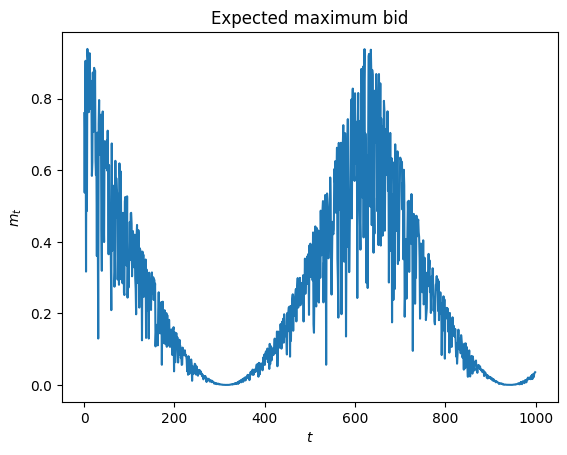

In [28]:
### Adversarial Bidders

n_advertisers = 3
n_users = 1000
B = 50

# non-trivial scenario: competitors sample bids from a uniform with range varying over time
pattern = lambda t: 1-np.abs(np.sin(5*t/n_users))
other_bids = np.array([np.random.uniform(0, pattern(t), size = n_advertisers) for t in range(n_users)]).T
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.

m_t = other_bids.max(axis=0)

plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

#### Adversarial baseline:
$$ maximize~~~ \sum_b \gamma(b)(v - b)\bar{\mathbb{P}}_m(b \ge m) ~~~ s.t. \sum_b b \gamma(b) \bar{\mathbb{P}}_m(b \ge m) \le \rho,$$
#### where $\gamma(b)$ is the probability of bidding $b$ and $\bar{\mathbb{P}}_m(b \ge m)$ is the empirical win probability over all rounds. This is a Linear Program! (LP)

In [29]:
available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

In [30]:
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

### Generalized Multiplicative Pacing for Non-Truthful Auctions

#### Here, we will assume a **full-feedback** setting. In auctions, full-feedback is equivalent of knowing the maximum bid $m_t$ that won the auction (of course, **after** the auction). Moreover, bids will be **discretized** into a finite set of actions.

#### We will leverage a full-feedback, adversarial learner such as Hedge (see Lab 2).

In [31]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [32]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]
    
    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

#### Let's try it in a stochastic environment

#### Setting:

In [33]:
### Stochastic Bidders: my competitors sample their bids from 
### probability distributions

n_advertisers = 3
n_users = 5000
B = 300
my_valuation = 0.6
rho = B/n_users

# simple scenario: competitors sample bids from a uniform 
other_bids = np.random.uniform(0, 1, size = (n_advertisers, n_users))
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.
m_t = other_bids.max(axis=0)

### the maximum among k uniformly distributed r.v.s is a beta r.v. with alpha=k and beta=1
available_bids = np.linspace(0,1,11)
win_probabilities = stats.beta.cdf(available_bids, n_advertisers, 1)

## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

#### Trial:

In [34]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = FirstPriceAuction(np.ones(n_advertisers+1))

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 480


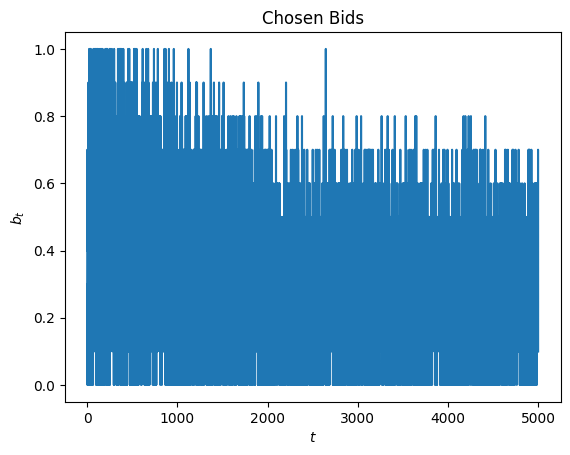

In [35]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

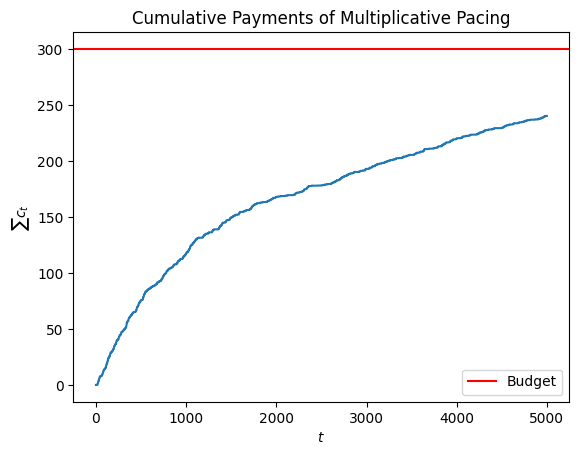

In [36]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

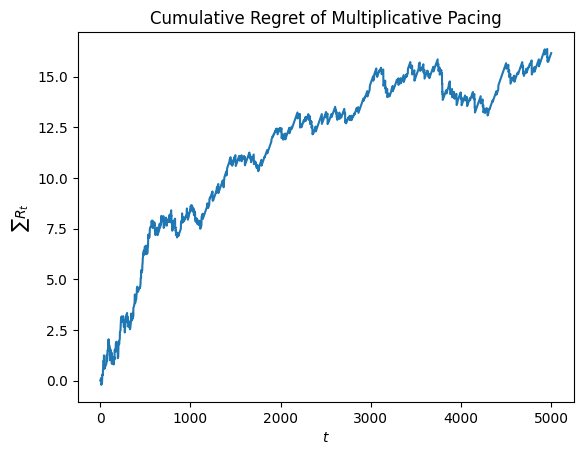

In [37]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

#### We need multiple rounds for a proper estimation

In [38]:
n_epochs = 50
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = FirstPriceAuction(np.ones(n_advertisers+1))
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

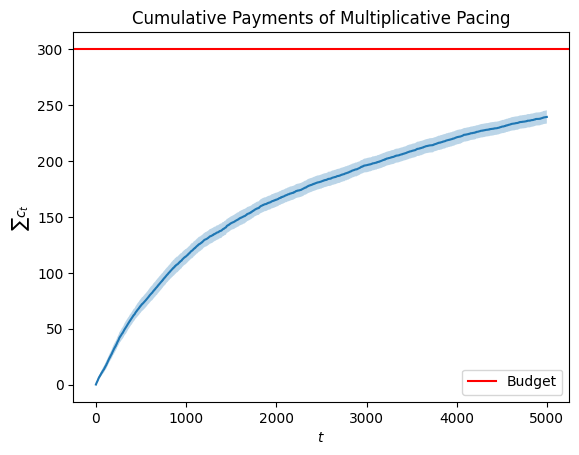

In [39]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

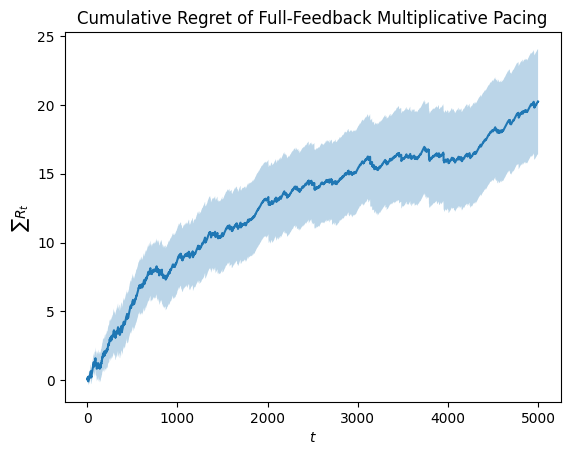

In [40]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()